In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

from scipy.linalg import eigh, norm
from scipy.sparse.linalg import expm_multiply
from scipy.fft import fft2
from tqdm import tqdm

# Functions

In [2]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
def HamPBC(N,J=1):
    dk = 2*np.pi/N
    # Considering the fact that scipy.fft.fft2 implements
    # a FBZ going from 0 to 2*pi, we have take into account a 
    # pi shift in the definition of k
    k = np.linspace(-np.pi,np.pi-dk,N) - np.pi
    kx, ky = np.meshgrid(k,k)

    A = np.diag(J*np.ravel(2 - 2*np.cos(ky)))
    C = np.diag(J*np.ravel(2 - 2*np.cos(kx)))
    B = -np.diag(J*(1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))
    A2 = np.roll(fft2(A/N**2)[::-1],1,axis=0)
    C2 = np.roll(fft2(C/N**2)[::-1],1,axis=0)
    B2 = np.roll(fft2(B/N**2)[::-1],1,axis=0)

    H = np.block([
        [A2,B2],
        [np.transpose(np.conjugate(B2)),C2]
    ])

    H = np.round(H,0)
    
    return np.real(H)

In [4]:
def HamOBC(N,J=1):
    dk = 2*np.pi/(N+2)
    k = np.linspace(-np.pi,np.pi-dk,N+2) - np.pi
    kx, ky = np.meshgrid(k,k)

    A = np.diag(J*np.ravel(2 - 2*np.cos(ky)))
    C = np.diag(J*np.ravel(2 - 2*np.cos(kx)))
    B = -np.diag(J*(1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))
    A2 = np.roll(fft2(A/(N+2)**2)[::-1],1,axis=0)
    C2 = np.roll(fft2(C/(N+2)**2)[::-1],1,axis=0)
    B2 = np.roll(fft2(B/(N+2)**2)[::-1],1,axis=0)
    
    mask = np.ones(((N+2)**2,(N+2)**2),dtype="bool")
    mask[:N+2,:] = mask[(N+2)*(N+1):,:] = False
    mask[:,:N+2] = mask[:,(N+2)*(N+1):] = False
    mask[::N+2,:] = mask[:,::N+2] = False
    mask[N+1::N+2,:] = mask[:,N+1::N+2] = False
    
    A2 = A2[mask].reshape(N**2,N**2)
    B2 = B2[mask].reshape(N**2,N**2)
    C2 = C2[mask].reshape(N**2,N**2)
    
    H = np.block([
        [A2,B2],
        [np.transpose(np.conjugate(B2)),C2]
    ])

    H = np.round(H,0)
    
    return np.real(H)

In [5]:
def HamOBC2(N,J=1):
    
    H = HamOBC(N)
    H[:N,:] = H[:,:N] = 0
    H[N**2 + N-1::N,:] = H[:,N**2 + N-1::N] = 0
    
    return H

In [6]:
def HamOBC3(N,J=1):
    
    H = HamOBC(N)
    H[:N**2:N,:] = H[:,:N**2:N] = 0
    H[N*(2*N-1):,:] = H[:,N*(2*N-1):] = 0 
    
    return H

In [7]:
def time_evol(H,tstart=0,tstop=1,Num=100,N_em=1,psi=[1.]):
    
    n = np.shape(H)[0]-N_em
    psi_in = np.array([0.]*n + psi)

    temp = expm_multiply(-1.j*H,psi_in,tstart,tstop,Num)
    
    return temp[:,-1], temp[:,:-1]

# Emitter coupled to the Checkerboard-I model (Period BCs)

In [604]:
N = 20
J = 1

g = 0.1
om_a = -1

## Local coupling

We define the Hamiltonian.

In [605]:
pos = (N+1)*N//2 # A site
coup = np.zeros((2*N**2,1))
coup[pos,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

We diagonalize it and plot the eigenvalues. 

In [606]:
eigval, eigvect = eigh(H)

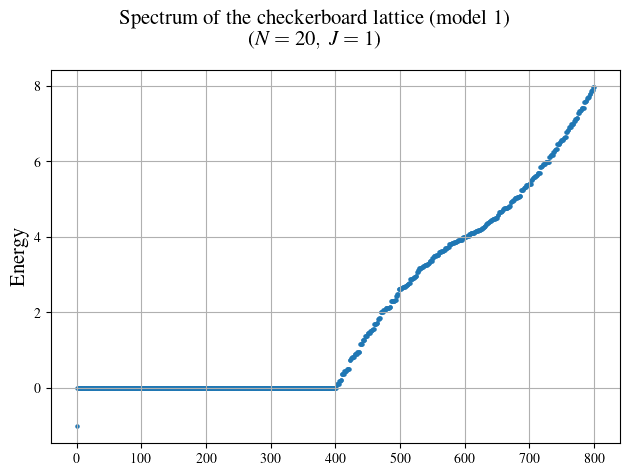

In [607]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

#plt.xlim(0,50)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

### Atom-photon bound state

Here, we show with a contour plot the shape of the atom-photon Bound State.

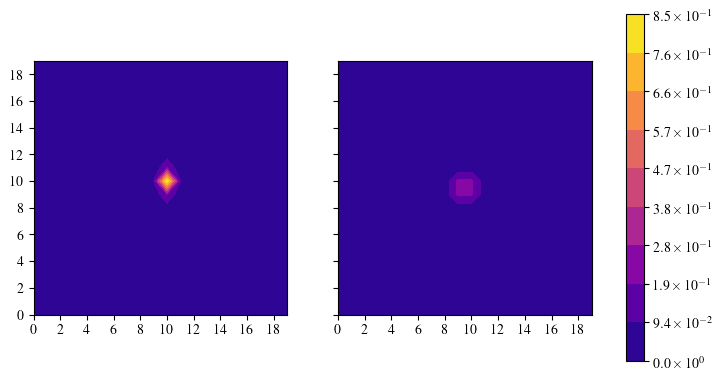

In [608]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(9,9))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,2))
ax[0].set_xticks(np.arange(0,N,2))
ax[1].set_xticks(np.arange(0,N,2))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

We plot sections in the two directions in order to show the behaviour.

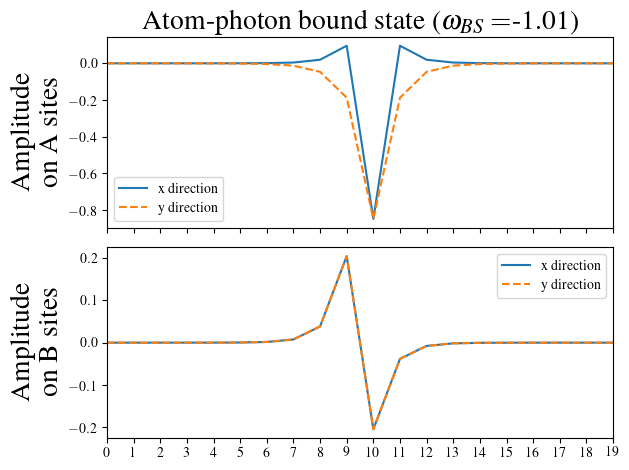

In [609]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)


ax[0].plot(np.arange(0,N,1),stateA[N//2,:],label="x direction")
ax[0].plot(np.arange(0,N,1),stateA[:,N//2],label="y direction",ls="--")

ax[1].plot(np.arange(0,N,1),stateB[N//2,:],label="x direction")
ax[1].plot(np.arange(0,N,1),stateB[:,N//2],label="y direction",ls="--")

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))

ax[0].legend()
ax[1].legend()
plt.show()

Here, we show the envelope of the bound state.

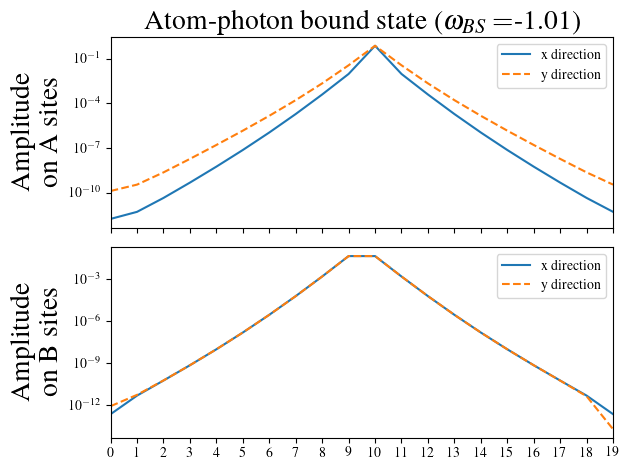

In [610]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)


ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:])**2,label="x direction")
ax[0].plot(np.arange(0,N,1),np.abs(stateA[:,N//2])**2,label="y direction",ls="--")

ax[1].plot(np.arange(0,N,1),np.abs(stateB[N//2,:])**2,label="x direction")
ax[1].plot(np.arange(0,N,1),np.abs(stateB[:,N//2])**2,label="y direction",ls="--")

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
#plt.savefig("eigs&spectra/bs.png")
plt.show()

### Dynamic in the single-excitation sector

We also study the dynamics in the single-excitation sector.

In [59]:
pop, phot = time_evol(H,0,500,500)

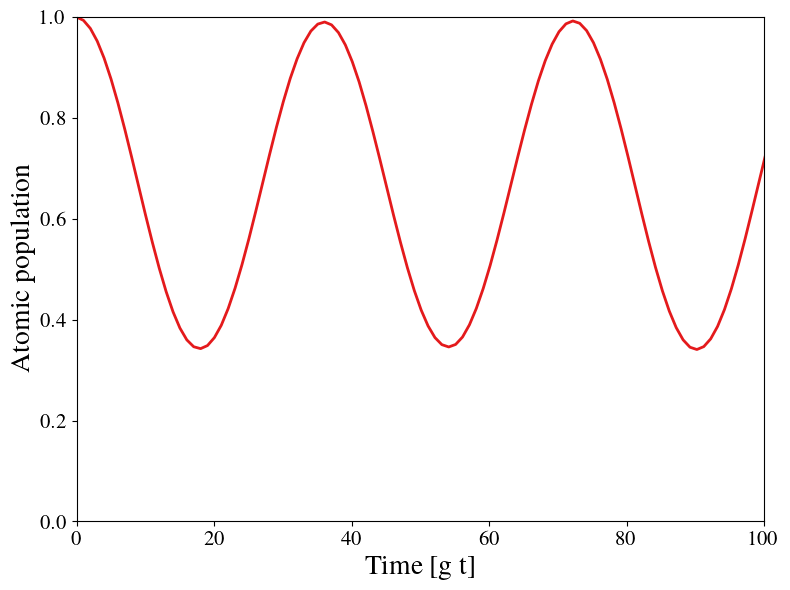

In [60]:
fig = plt.figure(figsize=(8,6),tight_layout=1)

pop_at = np.real(pop*np.conjugate(pop))
t = np.linspace(0,500,500)
plt.plot(t,pop_at,c='#e41a1c',lw=2,label="Numerics")

plt.xlabel("Time [g t]",fontsize=20)
plt.ylabel(f"Atomic population",fontsize=20)

plt.xlim(0,100)#t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)

plt.show()

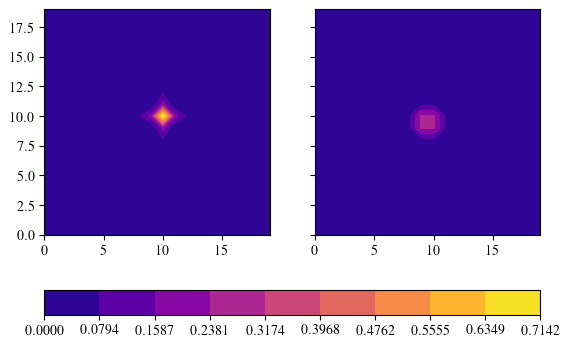

In [61]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 20

stateA = np.transpose(phot[s,:N**2].reshape(N,N))/norm(phot[s])
stateB = np.transpose(phot[s,N**2:].reshape(N,N))/norm(phot[s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)

ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

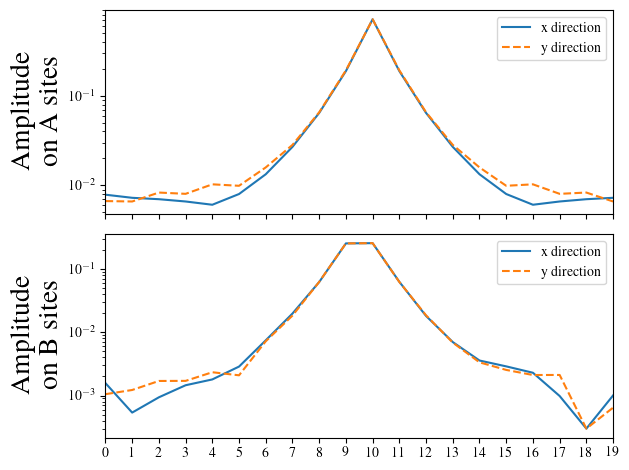

In [64]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)


ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:]),label="x direction")
ax[0].plot(np.arange(0,N,1),np.abs(stateA[:,N//2]),label="y direction",ls="--")

ax[1].plot(np.arange(0,N,1),np.abs(stateB[N//2,:]),label="x direction")
ax[1].plot(np.arange(0,N,1),np.abs(stateB[:,N//2]),label="y direction",ls="--")

ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
plt.show()

## Coupling to a CLS

We couple to a Compact Localized State in the form
\begin{equation}
    |\phi_{\textbf{R}}\rangle = \frac{1}{2} \Big\{ |a_{\textbf{R}}\rangle - |a_{\textbf{R} + x}\rangle + |b_{\textbf{R}}\rangle - |b_{\textbf{R} - y}\rangle \Big\}
\end{equation}

In [97]:
coup = np.zeros((2*N**2,1))

coup[(N+1)*N//2,0] -= g # A
coup[(N+1)*N//2 + N,0] += g # A
coup[(3*N+1)*N//2,0] -= g # B
coup[(3*N+1)*N//2 - 1,0] += g # B

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [98]:
eigval, eigvect = eigh(H)

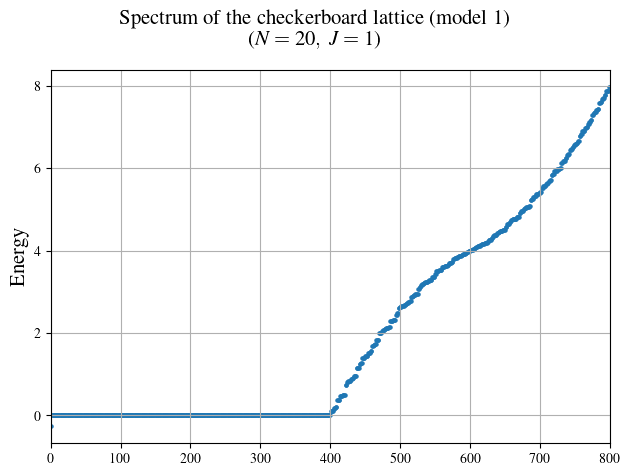

In [89]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

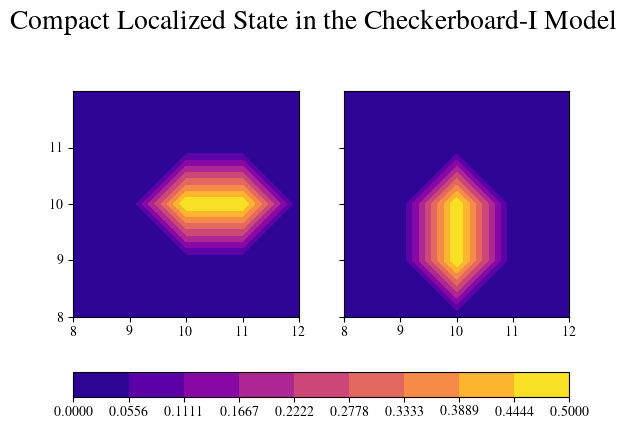

In [90]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.suptitle("Compact Localized State in the Checkerboard-I Model", fontsize=20)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateB))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(8,12)
ax[0].set_ylim(8,12)
ax[1].set_xlim(8,12)
ax[0].set_yticks(np.arange(8,12,1))

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

## Coupling to a NLS

In [100]:
coup = np.zeros((2*N**2,1))
pos = N**2//2
coup[pos:pos+N,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [101]:
eigval, eigvect = eigh(H)

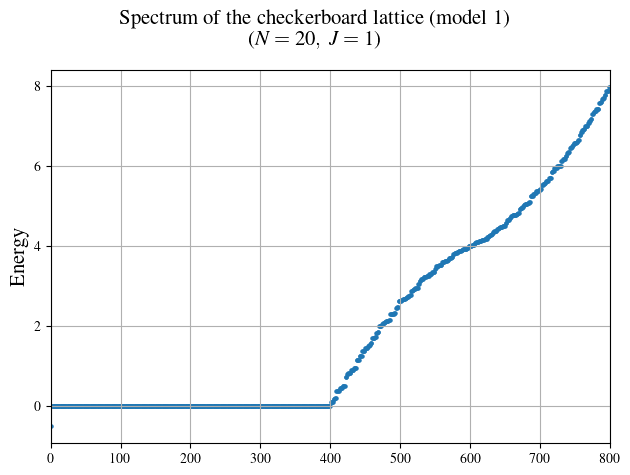

In [102]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

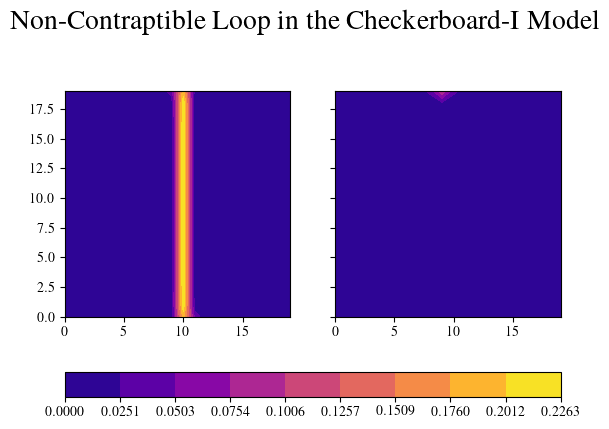

In [103]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.suptitle("Non-Contraptible Loop in the Checkerboard-I Model", fontsize=20)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

# Emitter coupled to the Checkerboard-I model (Open BCs)

In [598]:
N = 20
J = 1

g = 0.1
om_a = 1

## First way to terminate the lattice

### Bulk

In [117]:
coup = np.zeros((2*N**2,1))
pos =  N*(N+1)//2
coup[pos,0] -= g

H = np.block([
    [ HamOBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [118]:
eigval, eigvect = eigh(H)

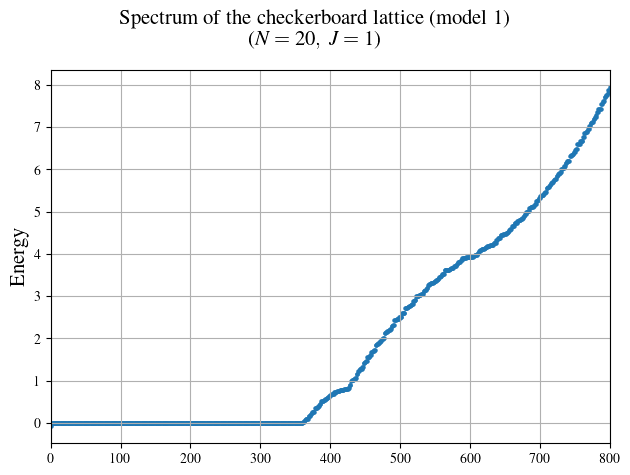

In [119]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

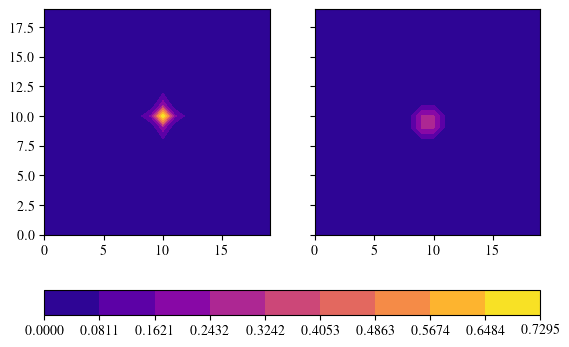

In [122]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

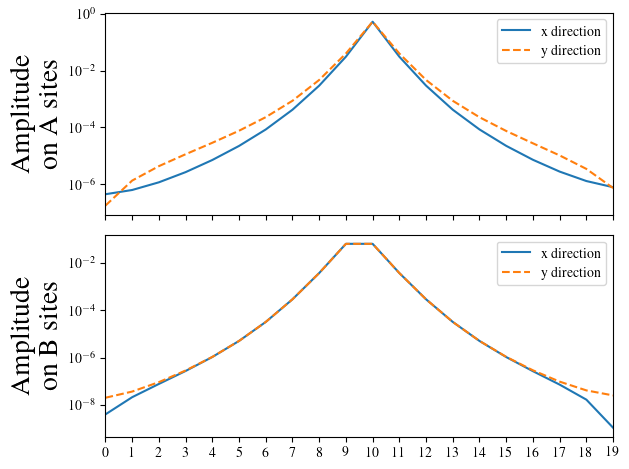

In [123]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)


ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:])**2,label="x direction")
ax[0].plot(np.arange(0,N,1),np.abs(stateA[:,N//2])**2,label="y direction",ls="--")

ax[1].plot(np.arange(0,N,1),np.abs(stateB[N//2,:])**2,label="x direction")
ax[1].plot(np.arange(0,N,1),np.abs(stateB[:,N//2])**2,label="y direction",ls="--")

ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
plt.show()

### Edge

In [599]:
coup = np.zeros((2*N**2,1))
pos = N**2 - N# N*(N+1)//2
coup[pos,0] -= g/np.sqrt(2)

#pos2 = N*(N-1)
#coup[pos2,0] -= g/np.sqrt(2)

H = np.block([
    [ HamOBC(N),coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [600]:
eigval, eigvect = eigh(H)

In [601]:
t = np.linspace(0,500,100)
pop, phot = time_evol(H,0,t[-1],len(t))

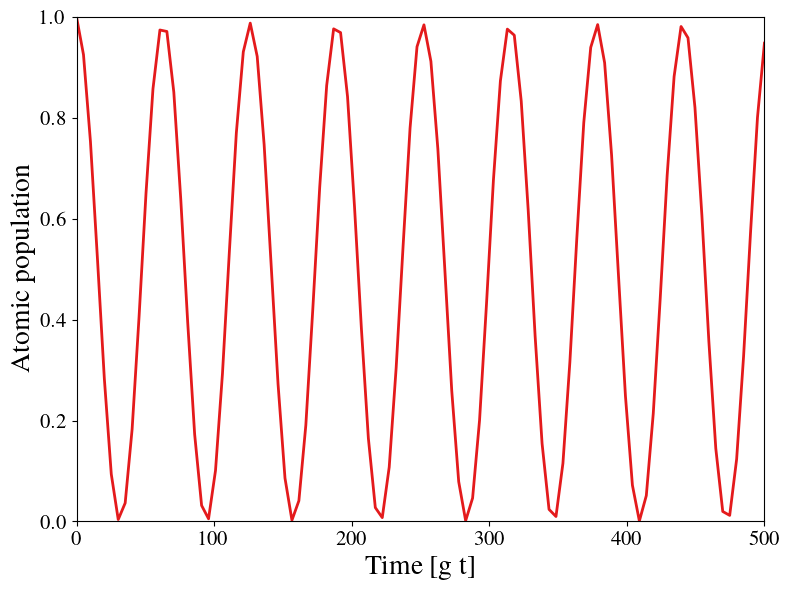

In [602]:
fig = plt.figure(figsize=(8,6),tight_layout=1)

pop_at = np.real(pop*np.conjugate(pop))

plt.plot(t,pop_at,c='#e41a1c',lw=2,label="Numerics")

plt.xlabel("Time [g t]",fontsize=20)
plt.ylabel(f"Atomic population",fontsize=20)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
#plt.yscale("log")

plt.show()

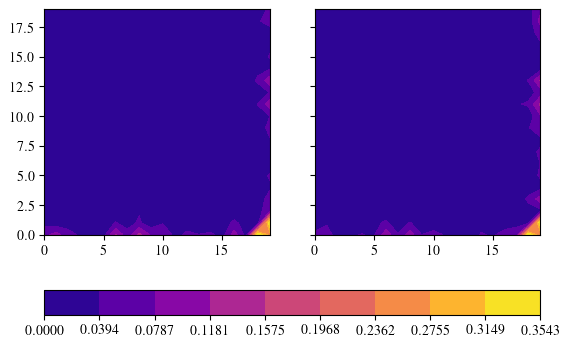

In [603]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 50

stateA = np.transpose(phot[s,:N**2].reshape(N,N))/norm(phot[s])
stateB = np.transpose(phot[s,N**2:].reshape(N,N))/norm(phot[s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)

ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

## Second way to terminate the lattice

## Third way to terminate the lattice

In [313]:
stateA1 = stateA
stateB1 = stateB

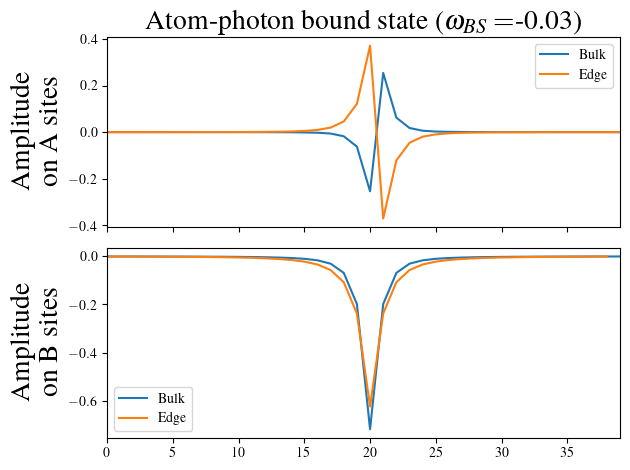

In [320]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

ax[0].plot(np.arange(0,N,1),stateA1[N//2,:],label="Bulk")
ax[0].plot(np.arange(0,N,1),stateA[1,:],label="Edge")

ax[1].plot(np.arange(0,N,1),stateB1[N//2,:],label="Bulk")
ax[1].plot(np.arange(0,N-1,1),stateB[0,:-1],label="Edge")


ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)


ax[0].set_xlim(0,N-1)
#ax[0].set_ylim(1e-4,1)
#ax[1].set_ylim(1e-4,1)
ax[0].set_xticks(np.arange(0,N,5))
#ax[0].set_yscale("log")
#ax[1].set_yscale("log")


ax[0].legend()
ax[1].legend()
#plt.savefig("eigs&spectra/comp2.png")
plt.show()